# Question 1 and 2 : CNN-based Facial Affect Analysis on Mobile Devices


## Task :

<ul>
<li>Train CNN based network on AffectNet dataset</li>
<li>AlexNet | VGGNett</li>
<li>MobileNet</li>

</ul>


## Import libraries and dataset


In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import os
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from google.colab import drive


In [114]:
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [115]:
drive_path = '/content/drive/MyDrive/HW2Q1-resources/'

In [121]:
os.chdir(drive_path)

In [116]:


!pwd

!unrar x NN_HW2_Face_Emotion.rar


/content/drive/MyDrive/HW2Q1-resources

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from NN_HW2_Face_Emotion.rar


Would you like to replace the existing file TUNE/anger/image0029836.jpg
  5225 bytes, modified on 2023-01-16 16:12
with a new one
  3408 bytes, modified on 2023-11-10 08:26

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
User break

User break


In [122]:
dataset_path = '/content/drive/MyDrive/HW2Q1-resources/'

train_path = os.path.join(dataset_path, 'TRAIN')
tune_path = os.path.join(dataset_path, 'TUNE')

### Emotions vs. valence/arousal

![Image](./Images/Q1-circumplex.png)
![Image](./Images/Q1-c.jpg)

. Arousal:

Arousal in AffectNet represents the intensity or activation level of an emotion expressed in a facial expression. It is a continuous measure, and higher values indicate more intense or activated emotional states.

. Valence:

Valence in AffectNet represents the positive or negative nature of an emotion expressed in a facial expression. Like arousal, valence is also a continuous measure. Positive valence values indicate positive emotions, while negative valence values indicate negative emotions.


## 2.1. Preprocessing and data augmentation


In [123]:
class_mapping = {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}


### Randomised data augmentation


In [124]:
def load_and_preprocess_images(path, num_samples, class_mapping):
    images = []
    labels = []

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    class_names = os.listdir(path)

    for class_name in class_names:
        class_path = os.path.join(path, class_name)
        class_images = os.listdir(class_path)[:num_samples]
        print(f"Class: {class_name}, Number of samples loaded: {len(class_images)}")

        for image_name in class_images:
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (128, 128))
            image = image / 255.0
            # Apply data augmentation
            img_array = image.reshape((1,) + image.shape)
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_image = batch[0]
                images.append(augmented_image)
                labels.append(class_mapping[class_name])
                break

            images.append(image)
            labels.append(class_mapping[class_name])

    return np.array(images), np.array(labels)

Load train data and fine tuned data


In [125]:
num_train_samples = 125 # load 125 from each category - > 1000 total samples
train_images, train_labels = load_and_preprocess_images(train_path, num_train_samples, class_mapping)


Class: anger, Number of samples loaded: 125
Class: contempt, Number of samples loaded: 125
Class: disgust, Number of samples loaded: 125
Class: fear, Number of samples loaded: 125
Class: happy, Number of samples loaded: 125
Class: neutral, Number of samples loaded: 125
Class: sad, Number of samples loaded: 125
Class: surprise, Number of samples loaded: 125


In [126]:
num_tune_samples = 25 # load 125 from each category - > 200 total samples
tune_images, tune_labels = load_and_preprocess_images(tune_path, num_tune_samples, class_mapping)


Class: anger, Number of samples loaded: 25
Class: contempt, Number of samples loaded: 25
Class: disgust, Number of samples loaded: 25
Class: fear, Number of samples loaded: 25
Class: happy, Number of samples loaded: 25
Class: neutral, Number of samples loaded: 25
Class: sad, Number of samples loaded: 25
Class: surprise, Number of samples loaded: 25


Split the data into training and testing sets (60% train, 40% test)


In [127]:
train_images, test_images, train_labels, test_labels = train_test_split(
    train_images, train_labels, test_size=0.4, random_state=42
)


shape


In [132]:
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)
print("Validation Images Shape:", tune_images.shape)
print("Validation Labels Shape:", tune_labels.shape)

Train Images Shape: (1200, 128, 128, 3)
Train Labels Shape: (1200,)
Test Images Shape: (800, 128, 128, 3)
Test Labels Shape: (800,)
Validation Images Shape: (400, 128, 128, 3)
Validation Labels Shape: (400,)


dispay images of the train sampels


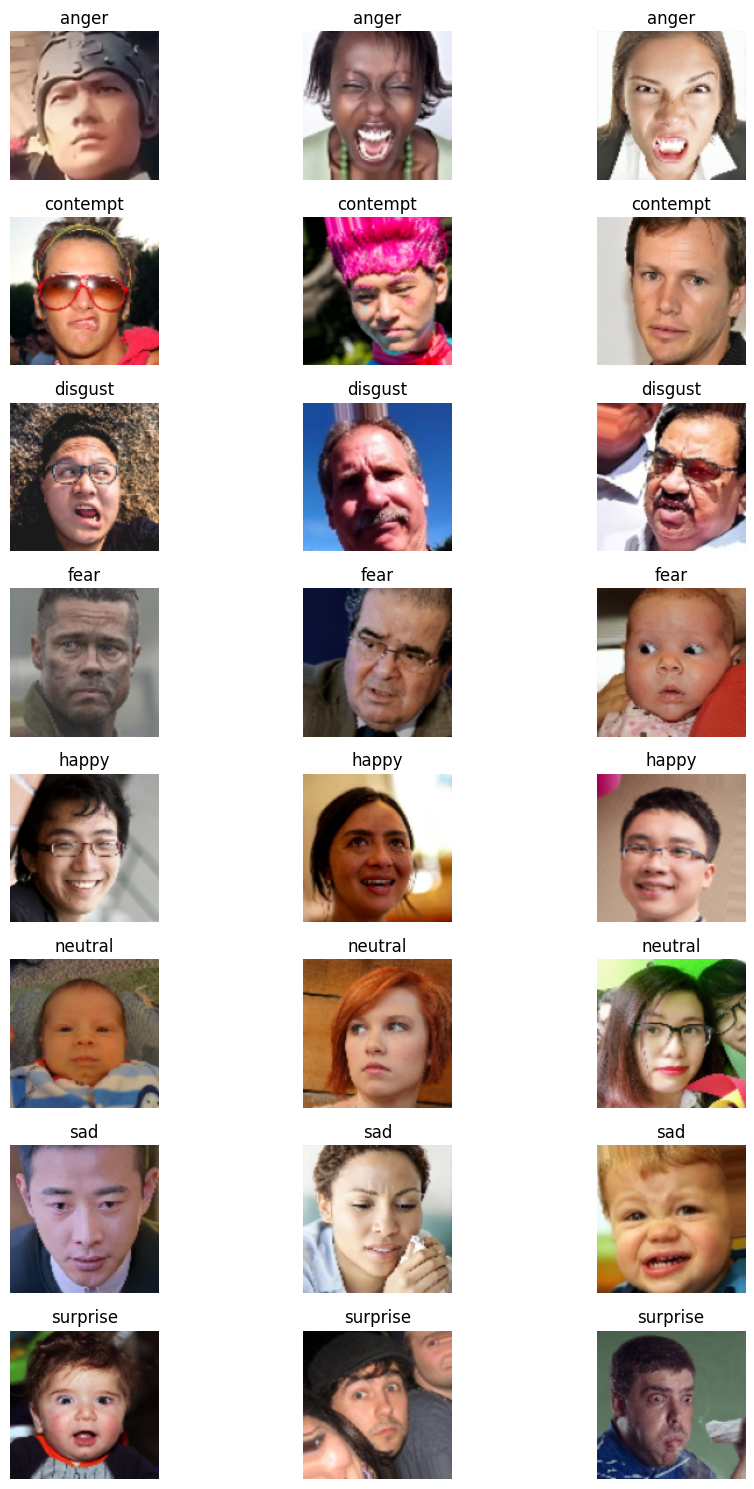

In [129]:
def display_sample_images(images, labels, class_mapping):
    num_classes = len(class_mapping)
    fig, axes = plt.subplots(nrows=num_classes, ncols=3, figsize=(10, 15))

    for i, class_name in enumerate(class_mapping.keys()):
        class_indices = np.where(labels == class_mapping[class_name])[0]
        sample_indices = np.random.choice(class_indices, size=3, replace=False)

        for j, sample_idx in enumerate(sample_indices):
            axes[i, j].imshow(images[sample_idx])
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(train_images, train_labels, class_mapping)


---

## 2.2. AlexNet


### Architecture


In [184]:
def create_affectnet_cnn(input_shape=(128, 128, 3), num_classes=8):
    model = Sequential()

    # Convolutional Block 1
    model.add(Conv2D(16, (9, 9), activation='relu', input_shape=input_shape, name='conv2d_input'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Convolutional Block 2
    model.add(Conv2D(32, (7, 7), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Convolutional Block 3
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Convolutional Block 4
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Convolutional Block 5
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Flatten
    model.add(Flatten())

    # Fully Connected (Dense) Layers
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer for Emotion Classification
    model.add(Dense(num_classes, activation='softmax', name='emotion_output'))

    return model

### Train model


In [194]:
train_labels_one_hot = to_categorical(train_labels, num_classes=8)
test_labels_one_hot = to_categorical(test_labels,num_classes=8)

In [186]:
model = create_affectnet_cnn(input_shape=(128, 128, 3), num_classes=8)

In [187]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [189]:
history = model.fit(train_images, train_labels_one_hot,
                    epochs=24,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/24
30/30 [==============================] - 47s 2s/step - loss: 2.2439 - accuracy: 0.1708 - val_loss: 2.3265 - val_accuracy: 0.0750
Epoch 2/24
30/30 [==============================] - 53s 2s/step - loss: 2.0963 - accuracy: 0.2333 - val_loss: 2.0876 - val_accuracy: 0.1500
Epoch 3/24
30/30 [==============================] - 47s 2s/step - loss: 2.0030 - accuracy: 0.2500 - val_loss: 2.0974 - val_accuracy: 0.1500
Epoch 4/24
30/30 [==============================] - 50s 2s/step - loss: 1.8999 - accuracy: 0.2750 - val_loss: 2.0117 - val_accuracy: 0.1958
Epoch 5/24
30/30 [==============================] - 47s 2s/step - loss: 1.8657 - accuracy: 0.2990 - val_loss: 2.0715 - val_accuracy: 0.2333
Epoch 6/24
30/30 [==============================] - 50s 2s/step - loss: 1.7827 - accuracy: 0.3073 - val_loss: 2.0318 - val_accuracy: 0.2167
Epoch 7/24
30/30 [==============================] - 46s 2s/step - loss: 1.7409 - accuracy: 0.3271 - val_loss: 1.9613 - val_accuracy: 0.2250
Epoch 8/24
30/30 [==

In [190]:
model.save('variantAlexNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [191]:
from keras.models import load_model

loaded_model = load_model('variantAlexNet.h5')

### Loss and Accuracy


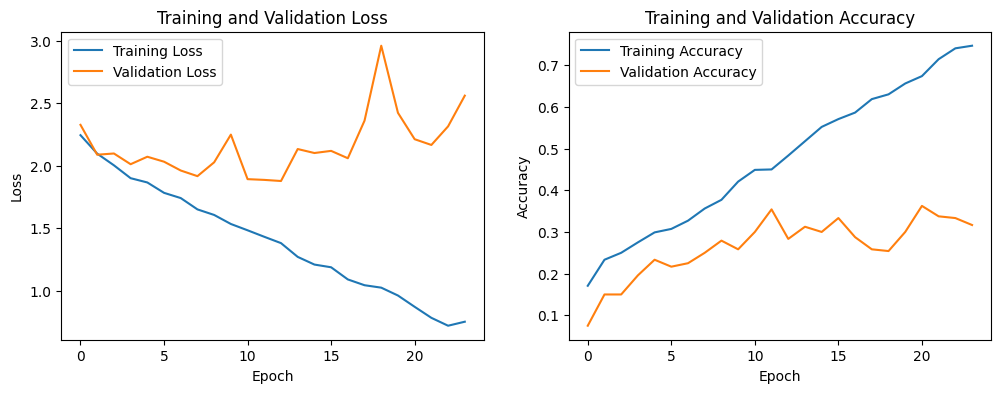

In [193]:
# Plot training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### ROC


25/25 [==============================] - 7s 265ms/step


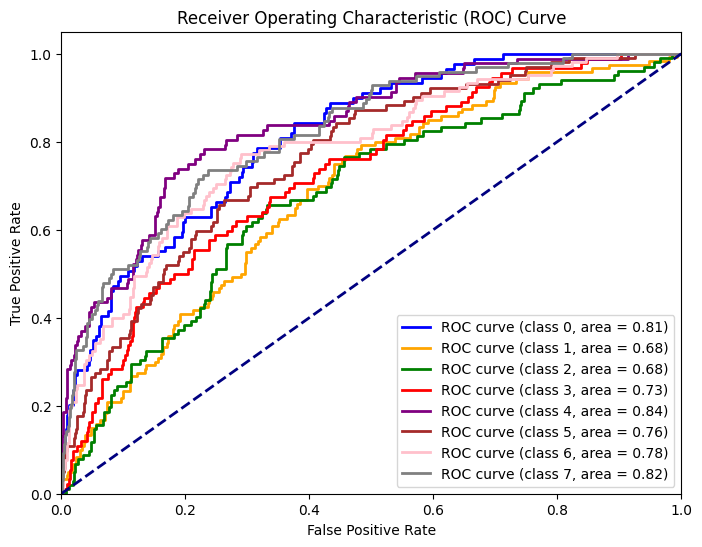

In [195]:
from sklearn.metrics import roc_curve, auc

y_score = model.predict(test_images)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = test_labels_one_hot.shape[1]

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Confusion matrix, F1, Recall, Accuracy


25/25 [==============================] - 8s 337ms/step


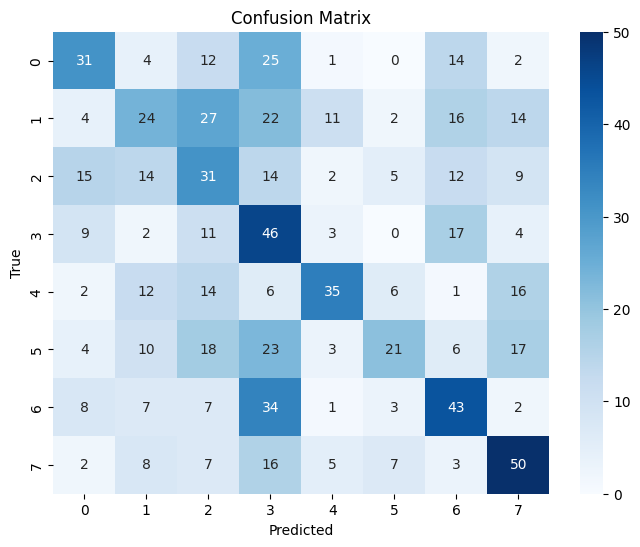

              precision    recall  f1-score   support

     Class 0       0.41      0.35      0.38        89
     Class 1       0.30      0.20      0.24       120
     Class 2       0.24      0.30      0.27       102
     Class 3       0.25      0.50      0.33        92
     Class 4       0.57      0.38      0.46        92
     Class 5       0.48      0.21      0.29       102
     Class 6       0.38      0.41      0.40       105
     Class 7       0.44      0.51      0.47        98

    accuracy                           0.35       800
   macro avg       0.38      0.36      0.35       800
weighted avg       0.38      0.35      0.35       800

Accuracy: 0.35


In [196]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels_one_hot, axis=1)

conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=[f'Class {i}' for i in range(num_classes)]))

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')


---

## 2.3. VGGNet


### Architecture


In [209]:
def create_vggnet_variant(input_shape=(128, 128, 3), num_classes=8):
    model = Sequential()
     # Convolutional Block 1
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv2d_input'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Convolutional Block 2
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Convolutional Block 3
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Convolutional Block 4
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Convolutional Block 5
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Flatten
    model.add(Flatten())

    # Fully Connected (Dense) Layers
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer for Emotion Classification
    model.add(Dense(num_classes, activation='softmax', name='emotion_output'))

    return model

### Train model


In [210]:
model_vggnet= create_vggnet_variant(input_shape=(128, 128, 3), num_classes=8)

In [211]:
model_vggnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [212]:
history_vggnet= model_vggnet.fit(train_images, train_labels_one_hot,
                    epochs=24,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/24
30/30 [==============================] - 24s 728ms/step - loss: 3.1514 - accuracy: 0.1375 - val_loss: 2.1460 - val_accuracy: 0.1208
Epoch 2/24
30/30 [==============================] - 21s 684ms/step - loss: 2.2645 - accuracy: 0.2240 - val_loss: 2.2310 - val_accuracy: 0.1500
Epoch 3/24
30/30 [==============================] - 21s 673ms/step - loss: 2.0875 - accuracy: 0.2552 - val_loss: 2.3926 - val_accuracy: 0.1208
Epoch 4/24
30/30 [==============================] - 24s 797ms/step - loss: 1.9319 - accuracy: 0.2917 - val_loss: 2.5657 - val_accuracy: 0.1125
Epoch 5/24
30/30 [==============================] - 20s 679ms/step - loss: 1.7972 - accuracy: 0.3333 - val_loss: 3.0162 - val_accuracy: 0.1167
Epoch 6/24
30/30 [==============================] - 22s 737ms/step - loss: 1.7531 - accuracy: 0.3573 - val_loss: 2.8319 - val_accuracy: 0.1583
Epoch 7/24
30/30 [==============================] - 20s 671ms/step - loss: 1.6256 - accuracy: 0.3833 - val_loss: 2.7344 - val_accuracy: 0.1292

save and load model


In [213]:
model.save('variantVGGNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [214]:
loaded_model = load_model('variantVGGNet.h5')

### loss and accuracy


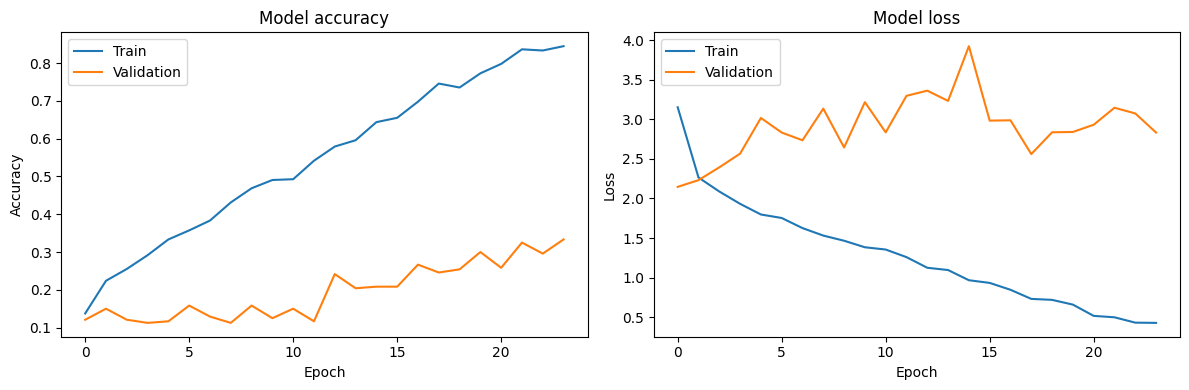

In [215]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_vggnet.history['accuracy'])
plt.plot(history_vggnet.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_vggnet.history['loss'])
plt.plot(history_vggnet.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### ROC


25/25 [==============================] - 11s 450ms/step


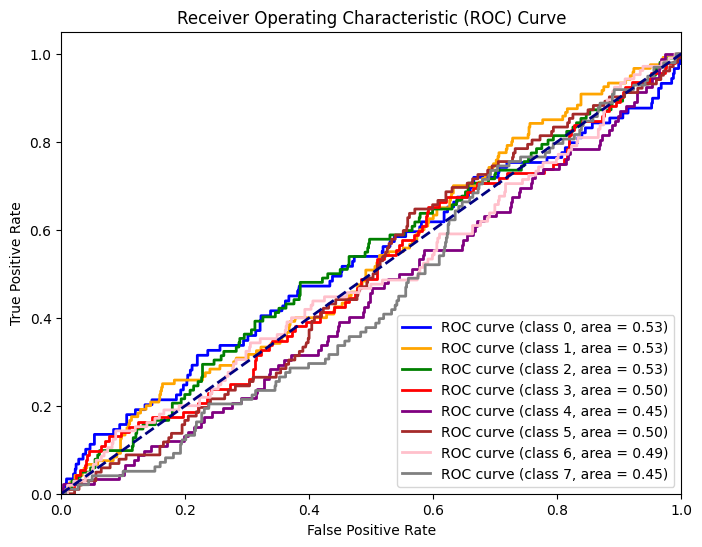

In [219]:
y_score = loaded_model.predict(test_images)

num_classes = y_score.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion matrix, F1, Recall, Accuracy


25/25 [==============================] - 4s 137ms/step


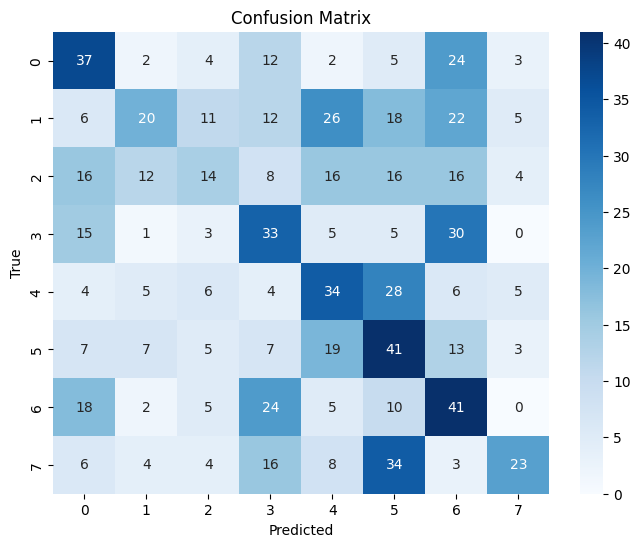

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.34      0.42      0.37        89
     Class 1       0.38      0.17      0.23       120
     Class 2       0.27      0.14      0.18       102
     Class 3       0.28      0.36      0.32        92
     Class 4       0.30      0.37      0.33        92
     Class 5       0.26      0.40      0.32       102
     Class 6       0.26      0.39      0.32       105
     Class 7       0.53      0.23      0.33        98

    accuracy                           0.30       800
   macro avg       0.33      0.31      0.30       800
weighted avg       0.33      0.30      0.30       800

Accuracy: 0.30


In [221]:
y_pred = model_vggnet.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels_one_hot, axis=1)

conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=[f'Class {i}' for i in range(num_classes)])
print("Classification Report:\n", class_report)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')


### Compare the VGGNet and AlexNet models and analyze and report the reasons for the difference in the results


- VGGNet Results:

Accuracy: 0.30

Key Observations:

Generally lower precision, recall, and F1-score across all classes compared to AlexNet.

The weighted average of precision, recall, and F1-score is 0.30.

- AlexNet Results:

Accuracy: 0.35

Key Observations:

Generally higher precision, recall, and F1-score compared to VGGNet.

The weighted average of precision, recall, and F1-score is 0.35.

- Analysis

AlexNet outperforms VGGNet with a higher overall accuracy.

AlexNet generally exhibits better precision, recall, and F1-score across most classes compared to VGGNet.

Class-wise analysis shows improvements in capturing true positives, reducing false positives and false negatives for AlexNet.

Both models have similar macro and weighted averages, but AlexNet's slightly higher values indicate better overall performance across classes.

- Reason: different type of stack 3\*3 used in VGGNet.


---

## 2.4. (bonus) - MobileNet


### Architecture


In [246]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense

def create_dconv_model(input_shape=(128, 128, 3), num_classes=8):
    model = Sequential()

    # Convolutional Block 1
    model.add(Conv2D(32, (3, 3), strides=2, activation='relu', input_shape=input_shape))
    # Depth-wise Separable Convolution Block 1
    model.add(DepthwiseConv2D((3, 3), strides=1, activation='relu'))
    model.add(DepthwiseConv2D((3, 3), strides=2, activation='relu'))
    model.add(DepthwiseConv2D((3, 3), strides=1, activation='relu'))

    # Depth-wise Separable Convolution Block 2
    model.add(DepthwiseConv2D((3, 3), strides=2, activation='relu', padding='same'))
    model.add(DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same'))

    # Depth-wise Separable Convolution Block 3
    model.add(DepthwiseConv2D((3, 3), strides=2, activation='relu', padding='same'))
    for _ in range(5):  # Repeat the block 5 times
        model.add(DepthwiseConv2D((3, 3), strides=1, activation='relu', padding='same'))

    # Depth-wise Separable Convolution Block 4
    model.add(DepthwiseConv2D((3, 3), strides=2, activation='relu'))
    model.add(DepthwiseConv2D((3, 3), strides=1, activation='relu'))

    # Global Average Pooling
    model.add(GlobalAveragePooling2D())

    # Fully Connected (Dense) Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model




### train model


In [ ]:
# Create the model
dconv_model = create_dconv_model()

# Display the model summary
dconv_model.summary()

In [251]:
dconv_model= create_dconv_model(input_shape=(128, 128, 3), num_classes=8)

In [252]:
optimizer = Adam(lr=0.001)
dconv_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [253]:
history_dconv = dconv_model.fit(
    train_images,
    to_categorical(train_labels, num_classes=8),
    epochs=24,
    batch_size=32,
    verbose=1,
    validation_split=0.2
)

Epoch 1/24
30/30 [==============================] - 8s 165ms/step - loss: 2.0796 - accuracy: 0.1146 - val_loss: 2.0802 - val_accuracy: 0.1167
Epoch 2/24
30/30 [==============================] - 6s 192ms/step - loss: 2.0790 - accuracy: 0.1240 - val_loss: 2.0805 - val_accuracy: 0.1208
Epoch 3/24
30/30 [==============================] - 5s 161ms/step - loss: 2.0785 - accuracy: 0.1354 - val_loss: 2.0811 - val_accuracy: 0.1042
Epoch 4/24
30/30 [==============================] - 4s 134ms/step - loss: 2.0782 - accuracy: 0.1417 - val_loss: 2.0813 - val_accuracy: 0.1042
Epoch 5/24
30/30 [==============================] - 5s 183ms/step - loss: 2.0777 - accuracy: 0.1417 - val_loss: 2.0819 - val_accuracy: 0.1042
Epoch 6/24
30/30 [==============================] - 5s 153ms/step - loss: 2.0774 - accuracy: 0.1417 - val_loss: 2.0822 - val_accuracy: 0.1042
Epoch 7/24
30/30 [==============================] - 4s 133ms/step - loss: 2.0772 - accuracy: 0.1417 - val_loss: 2.0827 - val_accuracy: 0.1042
Epoch 

save and load model


In [255]:
dconv_model.save('dconv_model.h5')

In [257]:
loaded_dconv_model = load_model('dconv_model.h5')

### Loss and Accuracy


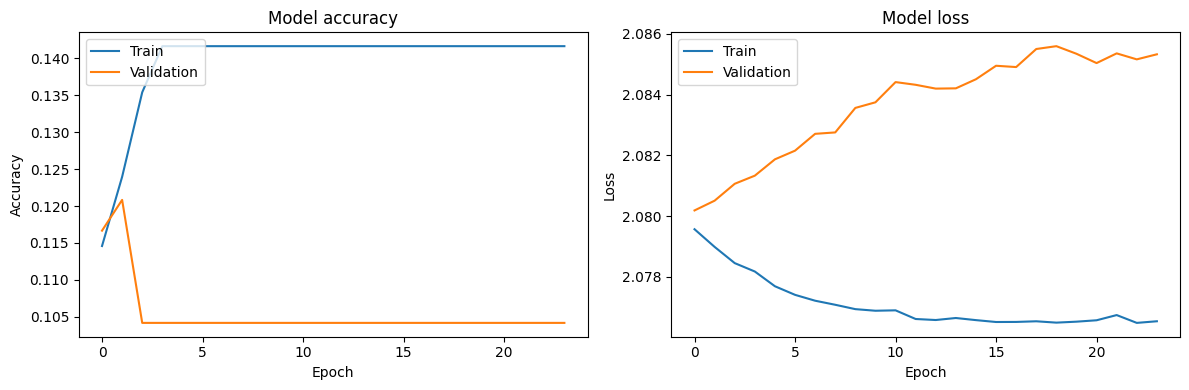

In [258]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dconv.history['accuracy'])
plt.plot(history_dconv.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_dconv.history['loss'])
plt.plot(history_dconv.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


### Confusion Matrix, F1, Recall, and Accuracy


25/25 [==============================] - 6s 169ms/step


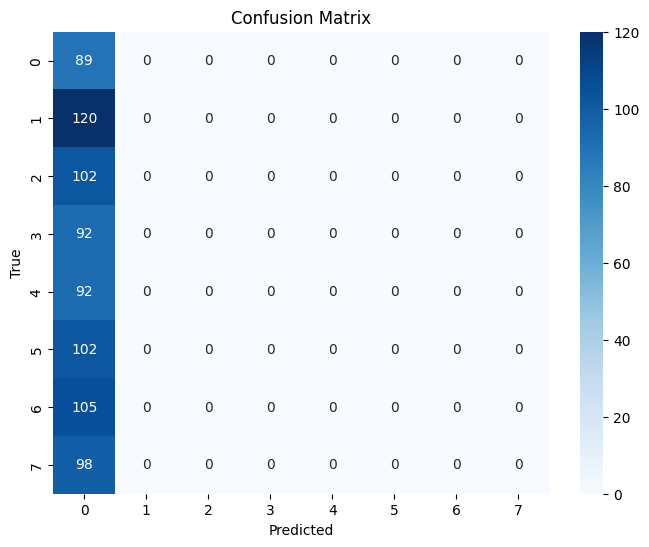

              precision    recall  f1-score   support

     Class 0       0.11      1.00      0.20        89
     Class 1       0.00      0.00      0.00       120
     Class 2       0.00      0.00      0.00       102
     Class 3       0.00      0.00      0.00        92
     Class 4       0.00      0.00      0.00        92
     Class 5       0.00      0.00      0.00       102
     Class 6       0.00      0.00      0.00       105
     Class 7       0.00      0.00      0.00        98

    accuracy                           0.11       800
   macro avg       0.01      0.12      0.03       800
weighted avg       0.01      0.11      0.02       800

Accuracy: 0.11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [260]:

test_pred = loaded_dconv_model.predict(test_images)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = np.argmax(test_labels_one_hot, axis=1)

conf_mat = confusion_matrix(test_true_classes, test_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_true_classes, test_pred_classes, target_names=[f'Class {i}' for i in range(num_classes)]))

accuracy = accuracy_score(test_true_classes, test_pred_classes)
print(f'Accuracy: {accuracy:.2f}')


### What is the difference between this model and the previous two models? Analyze and report the causes of the obtained results.


1. The DConv blocks are depthwise separable, which means they consist of a depthwise convolution layer followed by a pointwise convolution layer. The complexity introduced by these blocks may require different tuning and hyperparameters

2)DConv blocks typically have fewer parameters compared to regular convolutional layers, which might affect the model's ability to capture complex patterns in the data
